In [87]:
import pprint
import pandas as pd
import numpy as np
import evo.core.trajectory as et
from evo.core import metrics
from evo.core.units import Unit
import evo.tools.plot as ep
from evo.tools.pandas_bridge import df_to_trajectory
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [88]:
from evo.tools import log
log.configure_logging(verbose=True, debug=True, silent=False)
from evo.core import sync
# temporarily override some package settings
from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

ep.apply_settings(SETTINGS)
%matplotlib inline

[DEBUG][2025-03-15 21:36:34,613][log.configure_logging():113]
System info:
Python 3.9.5
Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.31
rodrigo@RODRIGO



In [89]:
import os
import sys

In [90]:
# Load the files
scene = "individual_files_validation_segment-10289507859301986274_4200_000_4220_000_with_camera_labels"
date = "202503151829"

# filepath of the csv file with the scene poses_data
poses_file_path = os.path.join(os.getcwd(), scene + "/" + date, "poses_" + scene + ".csv")
landmarks_file_path = os.path.join(os.getcwd(), scene + "/" + date, "landmarks_" + scene + ".csv")
print("Poses File Path:", poses_file_path)
print("Landmarks File Path:", landmarks_file_path)

Poses File Path: /home/rodrigo/catkin_ws/src/TFM_Landmark_Based_Localization/results/individual_files_validation_segment-10289507859301986274_4200_000_4220_000_with_camera_labels/202503151829/poses_individual_files_validation_segment-10289507859301986274_4200_000_4220_000_with_camera_labels.csv
Landmarks File Path: /home/rodrigo/catkin_ws/src/TFM_Landmark_Based_Localization/results/individual_files_validation_segment-10289507859301986274_4200_000_4220_000_with_camera_labels/202503151829/landmarks_individual_files_validation_segment-10289507859301986274_4200_000_4220_000_with_camera_labels.csv


In [91]:
data = pd.read_csv(poses_file_path)
data.shape

(198, 19)

In [92]:
data.head()

,frame,real_x,real_y,real_z,real_roll,real_pitch,real_yaw,odometry_x,odometry_y,odometry_z,odometry_roll,odometry_pitch,odometry_yaw,corrected_x,corrected_y,corrected_z,corrected_roll,corrected_pitch,corrected_yaw
0,[1],0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.025477,-0.009123,0.000000,0.000000,-0.000000,0.000000
1,[2],0.499197,-0.000814,0.001915,-0.001897,0.000956,-0.000485,0.838942,-0.054747,0.001915,-0.001897,0.000956,0.030628,0.813465,-0.063869,0.001915,-0.001897,0.000956,0.030628
2,[3],0.999919,-0.000109,0.001884,-0.001714,0.001724,-0.000298,1.617587,-0.137791,0.001825,-0.001720,0.001711,0.023777,1.348575,-0.676454,-0.000469,-0.002847,0.000615,0.028001
3,[4],1.503178,-0.002239,0.000974,-0.001346,0.001439,0.000087,2.284886,0.002637,0.000419,-0.001367,0.001412,0.016192,1.804251,-0.623071,-0.000794,-0.001445,0.000156,0.020434
4,[5],2.008165,-0.001622,-0.000880,0.001051,0.001055,0.000089,2.511968,0.249237,-0.001366,0.001027,0.001025,0.013970,2.030288,-0.375511,-0.002307,0.000952,-0.000231,0.018211


In [93]:
# Generar timestamps (10Hz)
timestamps = np.arange(len(data)) * 0.1

In [94]:
gt_positions = data[['real_x', 'real_y', 'real_z']].values
odometry_positions = data[['odometry_x', 'odometry_y', 'odometry_z']].values
estimated_positions = data[['corrected_x', 'corrected_y', 'corrected_z']].values

In [95]:
gt_orientations = data[['real_roll', 'real_pitch', 'real_yaw']].values
odometry_orientations = data[['odometry_roll', 'odometry_pitch', 'odometry_yaw']].values
estimated_orientations = data[['corrected_roll', 'corrected_pitch', 'corrected_yaw']].values

In [96]:
# Convertir ángulos de Euler a cuaterniones (formato w, x, y, z)
gt_rotations = R.from_euler('xyz', gt_orientations, degrees=False)
gt_quaternions = gt_rotations.as_quat()  # Devuelve (x, y, z, w), hay que reordenar a (w, x, y, z)
gt_quaternions = np.roll(gt_quaternions, shift=1, axis=1)  # Mover el último elemento al inicio

odometry_orientations = R.from_euler('xyz', odometry_orientations, degrees=False)
odometry_quaternions = odometry_orientations.as_quat()
odometry_quaternions = np.roll(odometry_quaternions, shift=1, axis=1)

estimated_orientations = R.from_euler('xyz', estimated_orientations, degrees=False)
estimated_quaternions = estimated_orientations.as_quat()
estimated_quaternions = np.roll(estimated_quaternions, shift=1, axis=1)


In [97]:
# Crear un DataFrame en formato evo
df_gt_evo = pd.DataFrame({
    "x": gt_positions[:, 0],
    "y": gt_positions[:, 1],
    "z": gt_positions[:, 2],
    "qw": gt_quaternions[:, 0],
    "qx": gt_quaternions[:, 1],
    "qy": gt_quaternions[:, 2],
    "qz": gt_quaternions[:, 3],
}, index=timestamps)

df_odometry_evo = pd.DataFrame({
    "x": odometry_positions[:, 0],
    "y": odometry_positions[:, 1],
    "z": odometry_positions[:, 2],
    "qw": odometry_quaternions[:, 0],
    "qx": odometry_quaternions[:, 1],
    "qy": odometry_quaternions[:, 2],
    "qz": odometry_quaternions[:, 3],
}, index=timestamps)

df_estimated_evo = pd.DataFrame({
    "x": estimated_positions[:, 0],
    "y": estimated_positions[:, 1],
    "z": estimated_positions[:, 2],
    "qw": estimated_quaternions[:, 0],
    "qx": estimated_quaternions[:, 1],
    "qy": estimated_quaternions[:, 2],
    "qz": estimated_quaternions[:, 3],
}, index=timestamps)

Trajectories

In [98]:
# Convertir DataFrame a PoseTrajectory3D
traj_gt = df_to_trajectory(df_gt_evo, as_type=et.PoseTrajectory3D)
traj_odometry = df_to_trajectory(df_odometry_evo, as_type=et.PoseTrajectory3D)
traj_estimated = df_to_trajectory(df_estimated_evo, as_type=et.PoseTrajectory3D)

In [99]:
max_diff = 0.01
traj_gt, traj_estimated = sync.associate_trajectories(traj_gt, traj_estimated, max_diff)

[DEBUG][2025-03-15 21:36:49,276][sync.associate_trajectories():110]
Found 198 of max. 198 possible matching timestamps between...
	first trajectory
and:	second trajectory
..with max. time diff.: 0.01 (s) and time offset: 0.0 (s).


In [100]:

import copy

traj_est_aligned = copy.deepcopy(traj_estimated)
traj_est_aligned.align(traj_gt, correct_scale=False, correct_only_scale=False)

[DEBUG][2025-03-15 21:36:50,137][trajectory.align():247]
Aligning using Umeyama's method...
[DEBUG][2025-03-15 21:36:50,145][trajectory.align():259]
Rotation of alignment:
[[ 0.99825362 -0.05711453 -0.01508784]
 [-0.04421012 -0.5529018  -0.83207275]
 [ 0.03918135  0.83128667 -0.55446126]]
Translation of alignment:
[ 0.24917908  0.70654778 -0.65283837]
[DEBUG][2025-03-15 21:36:50,149][trajectory.align():261]
Scale correction: 1.0


(array([[ 0.99825362, -0.05711453, -0.01508784],
        [-0.04421012, -0.5529018 , -0.83207275],
        [ 0.03918135,  0.83128667, -0.55446126]]),
 array([ 0.24917908,  0.70654778, -0.65283837]),
 1.0)

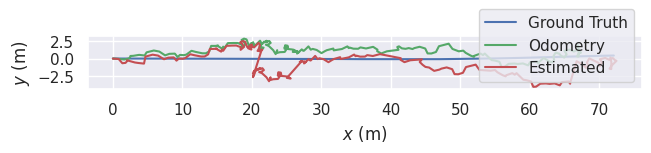

In [101]:
fig = plt.figure()
traj_by_label = {
    "Ground Truth": traj_gt,
    "Odometry": traj_odometry,
    "Estimated": traj_estimated
}
ep.trajectories(fig, traj_by_label, ep.PlotMode.xy)
plt.show()

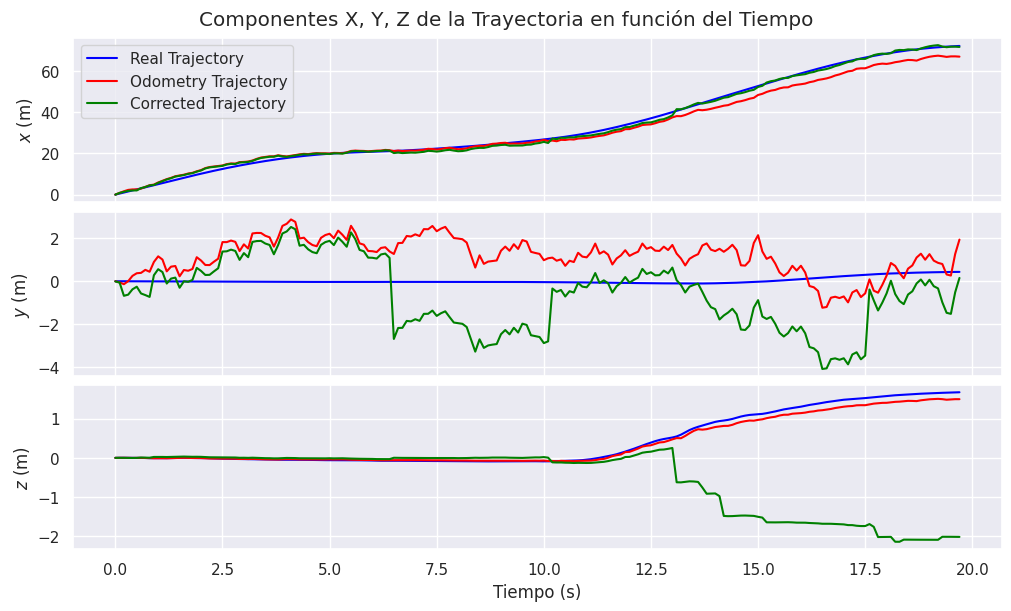

In [102]:
# Crear figura con 3 subgráficos
fig, axarr = plt.subplots(3, figsize=(10, 6), sharex=True)

# Graficar cada componente en función del tiempo
ep.traj_xyz(axarr, traj_gt, style='-', color='blue', label='Real Trajectory', start_timestamp=traj_gt.timestamps[0])
ep.traj_xyz(axarr, traj_odometry, style='-', color='red', label='Odometry Trajectory', start_timestamp=traj_odometry.timestamps[0])
ep.traj_xyz(axarr, traj_estimated, style='-', color='green', label='Corrected Trajectory', start_timestamp=traj_estimated.timestamps[0])

# Ajustes finales
plt.xlabel("Tiempo (s)")
plt.suptitle("Componentes X, Y, Z de la Trayectoria en función del Tiempo")
plt.show()

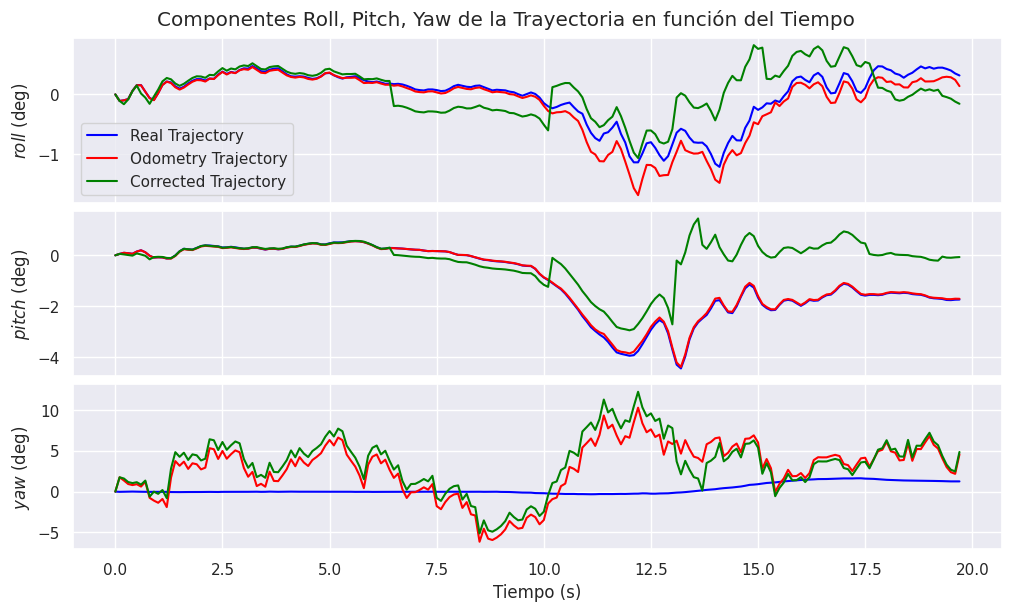

In [103]:
# Crear figura con 3 subgráficos
fig, axarr = plt.subplots(3, figsize=(10, 6), sharex=True)


# Graficar cada componente en función del tiempo
ep.traj_rpy(axarr, traj_gt, style='-', color='blue', label='Real Trajectory', start_timestamp=traj_gt.timestamps[0])
ep.traj_rpy(axarr, traj_odometry, style='-', color='red', label='Odometry Trajectory', start_timestamp=traj_odometry.timestamps[0])
ep.traj_rpy(axarr, traj_estimated, style='-', color='green', label='Corrected Trajectory', start_timestamp=traj_estimated.timestamps[0])

# Ajustes finales
plt.xlabel("Tiempo (s)")
plt.suptitle("Componentes Roll, Pitch, Yaw de la Trayectoria en función del Tiempo")
plt.show()

APE

In [104]:
# Settings
pose_relation = metrics.PoseRelation.translation_part
# Data preparation
data = (traj_gt, traj_est_aligned)
ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)
ape_stat = ape_metric.get_statistic(metrics.StatisticsType.rmse)
print(ape_stat)

[DEBUG][2025-03-15 21:42:10,470][metrics.process_data():412]
Compared 198 absolute pose pairs.
[DEBUG][2025-03-15 21:42:10,474][metrics.process_data():413]
Calculating APE for translation part pose relation...
1.7806054693388194


In [105]:
ape_stats = ape_metric.get_all_statistics()
pprint.pprint(ape_stats)

{'max': np.float64(2.9658821430776987),
 'mean': 1.670871871872027,
 'median': np.float64(1.7222752443169482),
 'min': np.float64(0.2765740104346829),
 'rmse': 1.7806054693388194,
 'sse': np.float64(627.7700558129848),
 'std': 0.615421014612099}


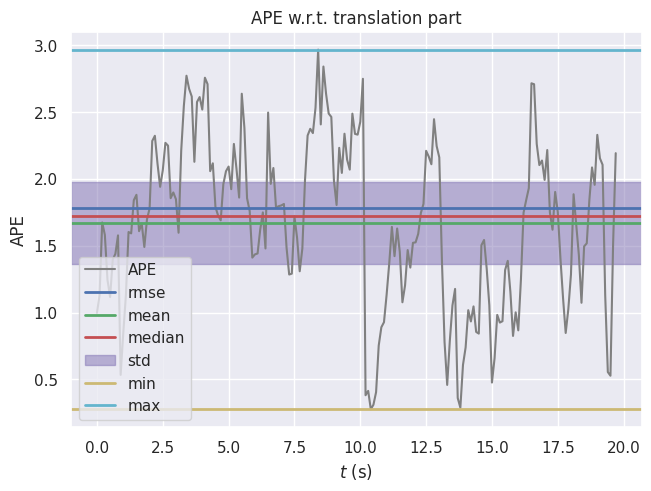

In [106]:
seconds_from_start = [t - traj_est_aligned.timestamps[0] for t in traj_est_aligned.timestamps]
fig = plt.figure()
ep.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                 name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

In [ ]:
plot_mode = ep.PlotMode.xy
fig = plt.figure()
ax = ep.prepare_axis(fig, plot_mode)
ep.traj(ax, plot_mode, traj_gt, '--', "gray", "reference")
ep.traj_colormap(ax, traj_estimated, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()

In [ ]:
tum_ate_equivalent = metrics.APE(metrics.PoseRelation.translation_part)
tum_ate_equivalent.process_data((traj_gt, traj_est_aligned))
print(tum_ate_equivalent.get_statistic(metrics.StatisticsType.rmse))

## Resultados de APE (Absolute Pose Error)

El APE (Absolute Pose Error) es una métrica utilizada para evaluar la precisión de una trayectoria estimada en comparación con una trayectoria de referencia (ground truth). En este caso, se ha calculado el APE entre la trayectoria estimada alineada y la trayectoria de referencia.

### Estadísticas del APE
Las estadísticas del APE incluyen varias medidas que describen la distribución de los errores de pose absolutos. Algunas de las estadísticas más relevantes son:

- **RMSE (Root Mean Square Error)**: Es una medida de la magnitud promedio del error. Se calcula como la raíz cuadrada de la media de los errores al cuadrado. Un RMSE más bajo indica una mayor precisión.
- **Mean**: Es el valor promedio de los errores. Proporciona una idea de la desviación promedio de la trayectoria estimada respecto a la trayectoria de referencia.
- **Median**: Es el valor mediano de los errores. Es menos sensible a valores atípicos en comparación con la media.
- **Min**: Es el valor mínimo de los errores. Indica el error más pequeño observado.
- **Max**: Es el valor máximo de los errores. Indica el error más grande observado.
- **Std (Standard Deviation)**: Es una medida de la dispersión de los errores. Un valor más bajo indica que los errores están más concentrados alrededor de la media.

### Visualización del APE
Se han generado varias visualizaciones para analizar el APE:

1. **Gráfico de errores en función del tiempo**: Muestra cómo varía el error absoluto de pose a lo largo del tiempo. Esto ayuda a identificar si hay momentos específicos en los que el error es mayor.
2. **Mapa de colores de la trayectoria**: Muestra la trayectoria estimada coloreada según el valor del error en cada punto. Esto permite identificar visualmente las áreas de la trayectoria con mayores errores.

### Interpretación de los Resultados
Los resultados del APE proporcionan una visión detallada de la precisión de la trayectoria estimada. Un RMSE bajo y una desviación estándar baja son indicativos de una trayectoria estimada que sigue de cerca la trayectoria de referencia. Las visualizaciones ayudan a identificar patrones y áreas problemáticas en la estimación de la trayectoria.

En resumen, el análisis del APE es fundamental para evaluar y mejorar la precisión de algoritmos de estimación de trayectoria en aplicaciones de navegación y robótica.

RPE

In [107]:
pose_relation = metrics.PoseRelation.rotation_angle_deg

# normal mode
delta = 1
delta_unit = Unit.frames

# all pairs mode
all_pairs = False  # activate

In [108]:

data = (traj_gt, traj_estimated)

In [109]:
rpe_metric = metrics.RPE(pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, all_pairs=all_pairs)
rpe_metric.process_data(data)

[DEBUG][2025-03-15 21:47:06,172][metrics.id_pairs_from_delta():469]
Found 197 pairs with delta 1 (frames) among 198 poses using consecutive pairs.
[DEBUG][2025-03-15 21:47:06,187][metrics.process_data():313]
Compared 197 relative pose pairs, delta = 1 (frames) with consecutive pairs.
[DEBUG][2025-03-15 21:47:06,189][metrics.process_data():319]
Calculating RPE for rotation angle in degrees pose relation...


In [110]:
rpe_stat = rpe_metric.get_statistic(metrics.StatisticsType.rmse)
print(rpe_stat)

1.248811223692186


In [111]:
rpe_stats = rpe_metric.get_all_statistics()
pprint.pprint(rpe_stats)

{'max': np.float64(5.155677655161757),
 'mean': 0.954441258807608,
 'median': np.float64(0.7366237137034588),
 'min': np.float64(0.00018668754567149908),
 'rmse': 1.248811223692186,
 'sse': np.float64(307.2273060666563),
 'std': 0.8053392799965267}


In [112]:
traj_ref_plot = copy.deepcopy(traj_gt)
traj_est_plot = copy.deepcopy(traj_estimated)
traj_ref_plot.reduce_to_ids(rpe_metric.delta_ids)
traj_est_plot.reduce_to_ids(rpe_metric.delta_ids)
seconds_from_start = [t - traj_estimated.timestamps[0] for t in traj_estimated.timestamps[1:]]

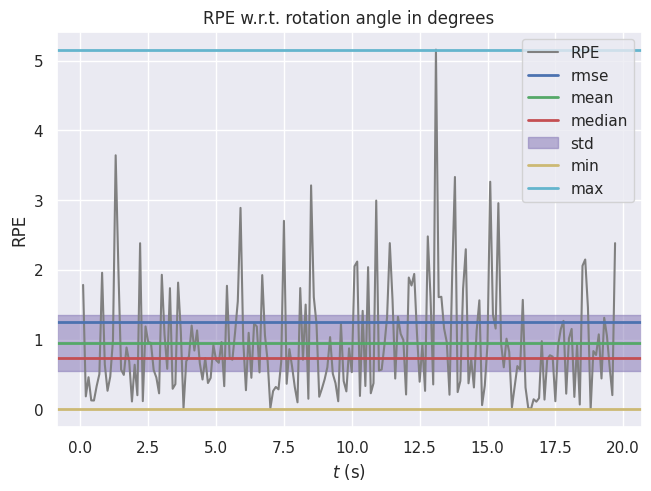

In [113]:
fig = plt.figure()
ep.error_array(fig.gca(), rpe_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in rpe_stats.items() if s != "sse"},
                 name="RPE", title="RPE w.r.t. " + rpe_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

In [ ]:
plot_mode = ep.PlotMode.xy
fig = plt.figure()
ax = ep.prepare_axis(fig, plot_mode)
ep.traj(ax, plot_mode, traj_ref_plot, '--', "gray", "reference")
ep.traj_colormap(ax, traj_est_plot, rpe_metric.error, plot_mode, min_map=rpe_stats["min"], max_map=rpe_stats["max"])
ax.legend()
plt.show()

In [ ]:
tum_rpe_equivalent = metrics.RPE(metrics.PoseRelation.translation_part, delta, Unit.frames, all_pairs=True)
tum_rpe_equivalent.process_data((traj_gt, traj_estimated))
print(tum_rpe_equivalent.get_statistic(metrics.StatisticsType.mean))